Paper Impact Prediction:

* The summary of the task is to predict a paper citation count using the title, year, author count, and venue dummy variables. 
* Determine important predictive features



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
df_reg = pd.read_parquet("../data/regression_df.parquet")

# basic cleaning
df_reg = df_reg.dropna(subset=["title", "venue", "year", "n_citation"])
df_reg["author_count"] = df_reg["authors"].apply(lambda x: len(x) if isinstance(x, list) else 0)

df_reg.head()

,abstract,authors,n_citation,references,title,venue,year,id,Abstract,author_count,text
0,The purpose of this study is to develop a lear...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,The purpose of this study is to develop a lear...,0,Preliminary Design of a Network Protocol Learn...
1,This paper describes the design and implementa...,"[Gareth Beale, Graeme Earl]",50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,visual analytics science and technology,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,This paper describes the design and implementa...,0,A methodology for the physically accurate visu...
2,This article applied GARCH model instead AR or...,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",50,"[2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...","Comparison of GARCH, Neural Network and Suppor...",pattern recognition and machine intelligence,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,This article applied GARCH model instead AR or...,0,"Comparison of GARCH, Neural Network and Suppor..."
3,None,"[Jea-Bum Park, Byungmok Kim, Jian Shen, Sun-Yo...",0,"[8c78e4b0-632b-4293-b491-85b1976675e6, 9cdc54f...",Development of Remote Monitoring and Control D...,,2011,00338203-9eb3-40c5-9f31-cbac73a519ec,,0,Development of Remote Monitoring and Control D...
4,None,"[Giovanna Guerrini, Isabella Merlo]",2,None,Reasonig about Set-Oriented Methods in Object ...,,1998,0040b022-1472-4f70-a753-74832df65266,,0,Reasonig about Set-Oriented Methods in Object ...


In [3]:
N = 20_000  # you can lower to 50_000 if needed

if len(df_reg) > N:
    df_reg_sample = df_reg.sample(N, random_state=42).copy()
else:
    df_reg_sample = df_reg.copy()

print("Sample size:", len(df_reg_sample))


Sample size: 20000


In [4]:

# 1) TF-IDF on titles (sparse)
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=3000,
    min_df=5,
)
X_title = tfidf.fit_transform(df_reg_sample["title"])

# 2) One-hot encode venue (sparse)
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
X_venue = ohe.fit_transform(df_reg_sample[["venue"]])

# 3) Numeric features as sparse
X_num = csr_matrix(df_reg_sample[["year", "author_count"]].values)

# 4) Combine all features (still sparse)
X = hstack([X_title, X_venue, X_num])
y = df_reg_sample["n_citation"].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (20000, 5315)
y shape: (20000,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape

((16000, 5315), (4000, 5315))

In [6]:
#Linear regression 
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [7]:
#Random Forest Regressor

#Train on a 5k subset for speed
subset_size = 5000  
subset_size = min(subset_size, X_train.shape[0])

#choose random indices for the subset
idx_rf = np.random.choice(X_train.shape[0], size=subset_size, replace=False)

X_train_subset = X_train[idx_rf]
y_train_subset = y_train[idx_rf]

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_subset, y_train_subset)
y_pred_rf = rf.predict(X_test)

In [8]:
#Gradient Boosting Regressor
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [9]:
#Evaluate models

def eval_reg(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }

lr_metrics = eval_reg(y_test, y_pred_lr)
rf_metrics = eval_reg(y_test, y_pred_rf)
gb_metrics = eval_reg(y_test, y_pred_gb)

lr_metrics, rf_metrics, gb_metrics


({'RMSE': np.float64(50.42777085911706),
  'MAE': 34.46911974491341,
  'R2': -0.18391928350415787},
 {'RMSE': np.float64(45.928114526943084),
  'MAE': 27.61618,
  'R2': 0.01793601065934647},
 {'RMSE': np.float64(44.62468812857988),
  'MAE': 27.962889708952208,
  'R2': 0.07288642378453436})

In [10]:
#Results comparison table
results_df = pd.DataFrame([
    ["Linear Regression", lr_metrics["RMSE"], lr_metrics["MAE"], lr_metrics["R2"]],
    ["Random Forest", rf_metrics["RMSE"], rf_metrics["MAE"], rf_metrics["R2"]],
    ["Gradient Boosting", gb_metrics["RMSE"], gb_metrics["MAE"], gb_metrics["R2"]],
], columns=["Model", "RMSE", "MAE", "R2"])

#round to 3 decimals
results_df = results_df.round(3)
results_df


,Model,RMSE,MAE,R2
0,Linear Regression,50.428,34.469,-0.184
1,Random Forest,45.928,27.616,0.018
2,Gradient Boosting,44.625,27.963,0.073


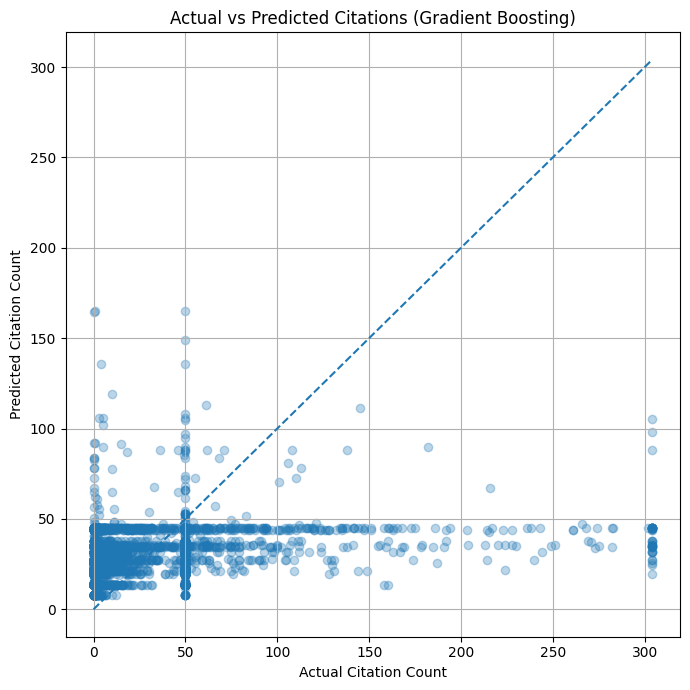

In [11]:
#Plot actual vs predicted for Gradient Boosting model

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_gb, alpha=0.3)
max_val = max(y_test.max(), y_pred_gb.max())
plt.plot([0, max_val], [0, max_val], linestyle="--")  # y = x line

plt.xlabel("Actual Citation Count")
plt.ylabel("Predicted Citation Count")
plt.title("Actual vs Predicted Citations (Gradient Boosting)")
plt.grid(True)

plt.tight_layout()
plt.savefig("../figures/regression_plot.png", dpi=300)
plt.show()


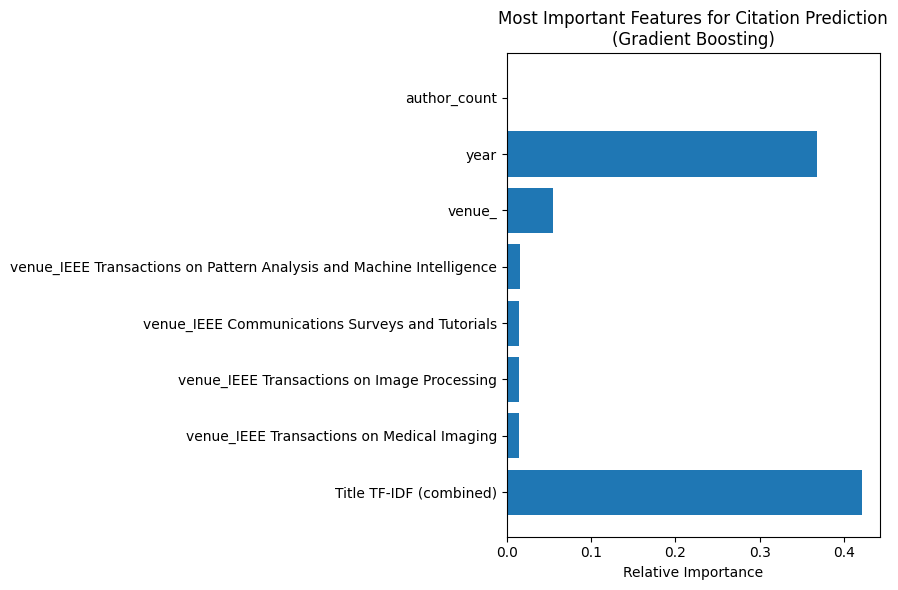

In [ ]:
#Feature importance from Gradient Boosting model


n_title = X_title.shape[1]
n_venue = X_venue.shape[1]

importances = gb.feature_importances_

# Aggregate title TF-IDF importance
title_importance = importances[:n_title].sum()

# Venue importances + names
venue_importances = importances[n_title:n_title + n_venue]
venue_names = ohe.get_feature_names_out(["venue"])

# pick top 5 venues
top_k = 5
top_idx = np.argsort(venue_importances)[-top_k:]
top_venue_names = venue_names[top_idx]
top_venue_importances = venue_importances[top_idx]


numeric_importances = importances[n_title + n_venue:]
numeric_names = ["year", "author_count"]

# Combine for plotting
labels = ["Title TF-IDF (combined)"] + list(top_venue_names) + numeric_names
values = [title_importance] + list(top_venue_importances) + list(numeric_importances)

plt.figure(figsize=(9, 6))
y_pos = np.arange(len(labels))
plt.barh(y_pos, values)
plt.yticks(y_pos, labels)
plt.xlabel("Relative Importance")
plt.title("Most Important Features for Citation Prediction\n(Gradient Boosting)")

plt.tight_layout()
plt.savefig("../figures/feature_importance_regression.png", dpi=300)
plt.show()
